In [657]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark.sql.types
import datetime
import missingno as msno
from pyecharts.charts import Bar, Scatter, Line, Funnel
from pyecharts import options as opts

In [658]:
app_name = "name"
db_path = "db"
spark = SparkSession.builder.appName(app_name).enableHiveSupport().getOrCreate()
observations = spark.read.format("parquet").load(db_path+'/observations')
conditions = spark.read.format("parquet").load(db_path+'/conditions')
patients = spark.read.format("parquet").load(db_path+'/patients')
questionnaire = spark.read.format("parquet").load(db_path+'/questionnaire_responses')

In [659]:
def df_column_to_list(df:pyspark.sql.dataframe.DataFrame, col_name, distinct=False)->list:
    '''
    - df
    - col_name

    Returns the list of col_name
    '''
    if distinct:
        return list(df.select(col_name).distinct().toPandas()[col_name])
    else:
        return list(df.select(col_name).toPandas()[col_name])

In [660]:
df = conditions
pd.DataFrame(df.toPandas()).head()

,id,onsetDateTime,resourceType,subject_reference,meta_lastUpdated,meta_source,meta_versionId,encounter_reference,clinicalStatus_coding_code,clinicalStatus_coding_system,code_coding_code,code_coding_display,code_coding_system,meta_profile,verificationStatus_coding_code,verificationStatus_coding_system,category_coding_code,category_coding_display,category_coding_system
0,23,2021-10-24 18:43:39.942,Condition,Patient/1550736443,2021-10-24 18:43:39,#2TKhmJ1wzYgLnCA3,1,Encounter/2,active,http://terminology.hl7.org/CodeSystem/conditio...,164971000119101,Diabetes type II on diet,http://snomed.info/sct,https://140.164.14.210/fhir/StructureDefinitio...,confirmed,http://terminology.hl7.org/CodeSystem/conditio...,encounter-diagnosis,Encounter Diagnosis,http://terminology.hl7.org/CodeSystem/conditio...
1,23,2021-10-24 18:43:39.942,Condition,Patient/1550736443,2021-10-24 18:43:39,#2TKhmJ1wzYgLnCA3,1,Encounter/2,active,http://terminology.hl7.org/CodeSystem/conditio...,164971000119101,Diabetes type II on diet,http://snomed.info/sct,https://140.164.14.210/fhir/StructureDefinitio...,confirmed,http://terminology.hl7.org/CodeSystem/conditio...,439401001,Diagnosis,http://snomed.info/sct
2,24,2021-10-24 18:43:39.944,Condition,Patient/1550736443,2021-10-24 18:43:39,#2TKhmJ1wzYgLnCA3,1,Encounter/2,active,http://terminology.hl7.org/CodeSystem/conditio...,386806002,Impaired cognition,http://snomed.info/sct,https://140.164.14.210/fhir/StructureDefinitio...,confirmed,http://terminology.hl7.org/CodeSystem/conditio...,439401001,Diagnosis,http://snomed.info/sct
3,24,2021-10-24 18:43:39.944,Condition,Patient/1550736443,2021-10-24 18:43:39,#2TKhmJ1wzYgLnCA3,1,Encounter/2,active,http://terminology.hl7.org/CodeSystem/conditio...,386806002,Impaired cognition,http://snomed.info/sct,https://140.164.14.210/fhir/StructureDefinitio...,confirmed,http://terminology.hl7.org/CodeSystem/conditio...,encounter-diagnosis,Encounter Diagnosis,http://terminology.hl7.org/CodeSystem/conditio...
4,25,2021-10-24 18:43:39.946,Condition,Patient/1550736443,2021-10-24 18:43:39,#2TKhmJ1wzYgLnCA3,1,Encounter/2,active,http://terminology.hl7.org/CodeSystem/conditio...,197480006,Anxiety disorder,http://snomed.info/sct,https://140.164.14.210/fhir/StructureDefinitio...,confirmed,http://terminology.hl7.org/CodeSystem/conditio...,439401001,Diagnosis,http://snomed.info/sct


In [661]:
df = df.filter(df['clinicalStatus_coding_code'] == 'active')
df = df.groupBy('code_coding_display').count()
df = df.orderBy('count',ascending=False)
pd.DataFrame(df.toPandas()).head()

,code_coding_display,count
0,Hypertension,32
1,Anxiety disorder,20
2,Depression,18
3,Impaired cognition,12
4,Diabetes type II on diet,12


In [662]:
# plt.bar(df['code_coding_display'], df['count'])
# plt.xticks(df['code_coding_display'], df['code_coding_display'], rotation='vertical')

In [663]:
bar = Bar()
bar.add_xaxis(df_column_to_list(df,'code_coding_display'))
bar.add_yaxis('conditions', df_column_to_list(df,'count')
    # scale=True
    )
bar.reversal_axis()
bar.set_series_opts(label_opts=opts.LabelOpts(position='right'))
bar.set_global_opts(
        title_opts=opts.TitleOpts(title="Conditions count")
        )
bar.render_notebook()

In [664]:
df = pd.DataFrame(df.toPandas())

fu = Funnel()
fu.add("conditions", [list(z) for z in zip(df['code_coding_display'], df['count'])])
fu.set_global_opts(title_opts=opts.TitleOpts(title="Conditions count"),
    legend_opts=opts.LegendOpts(is_show=False))
fu.render_notebook()

In [665]:
df = observations
pd.DataFrame(df.toPandas()).head()

,effectiveDateTime,id,resourceType,status,valueInteger,valueQuantity_code,valueQuantity_system,valueQuantity_unit,valueQuantity_value,subject_reference,...,component_valueSampledData_data,component_valueSampledData_dimensions,component_valueSampledData_period,component_valueSampledData_origin_code,component_valueSampledData_origin_system,component_valueSampledData_origin_unit,component_code_text,component_code_coding_version,component_valueSampledData_extension_url,component_valueSampledData_extension_valueString
0,2022-02-12 09:24:14,27654,Observation,final,NaN,None,None,None,NaN,Patient/512815964,...,None,NaN,NaN,None,None,None,Total number of head turns performed,http://snomed.info/sct/900000000000207008/vers...,None,None
1,2022-02-12 09:24:14,27654,Observation,final,NaN,None,None,None,NaN,Patient/512815964,...,None,NaN,NaN,None,None,None,None,None,None,None
2,2022-02-12 09:24:14,27654,Observation,final,NaN,None,None,None,NaN,Patient/512815964,...,None,NaN,NaN,None,None,None,None,2.69,None,None
3,2022-02-12 09:24:14,27654,Observation,final,NaN,None,None,None,NaN,Patient/512815964,...,72.48 69.96 67.13 62.16 68.76 69.97 65.97 71.5...,1.0,1000.0,deg,http://unitsofmeasure.org,degree,Range of head turns in pitch plane (Up-Down),None,https://holobalance.eu/fhir/offsets,1714 3428 5142 6856 8570 10284 11998 13712 154...
4,2022-02-12 09:24:14,27654,Observation,final,NaN,None,None,None,NaN,Patient/512815964,...,3.23 3.23 4.35 2.63 3.70 2.17 3.03 3.23 1.52 1...,1.0,1000.0,/s,http://unitsofmeasure.org,per second,Head turns per second,None,https://holobalance.eu/fhir/offsets,1714 3428 5142 6856 8570 10284 11998 13712 154...


In [666]:
PATIENT='Patient_id'
SUBJECT='subject_reference'
CODE='code_coding_code'
CMP_CODE='component_code_coding_code'
VALUE='valueQuantity_value'
CMP_VALUE='component_valueQuantity_value'
TIME='effectiveDateTime'
LOCAL_TIME='local_time'
TIMESTAMP='timestamp'

In [667]:
def select_observations():
    '''
    returns: 
    '''
    df = observations
    df = df.select(
        SUBJECT,
        TIME,
        CODE,
        CMP_CODE,
        VALUE,
        CMP_VALUE
    )
    return df

In [668]:
df = select_observations()
pd.DataFrame(df.toPandas()).head()

,subject_reference,effectiveDateTime,code_coding_code,component_code_coding_code,valueQuantity_value,component_valueQuantity_value
0,Patient/512815964,2022-02-12 09:24:14,1159,1202026006,NaN,35.0
1,Patient/512815964,2022-02-12 09:24:14,1159,228450008,NaN,60.0
2,Patient/512815964,2022-02-12 09:24:14,1159,89191-1,NaN,1.0
3,Patient/512815964,2022-02-12 09:24:14,1159,404979006,NaN,NaN
4,Patient/512815964,2022-02-12 09:24:14,1159,282108002,NaN,NaN


In [669]:
def filter(
    df:pyspark.sql.dataframe.DataFrame,
    **kwargs
)->pyspark.sql.dataframe.DataFrame:
    '''
    A Shortcut for filtering by values , null and None
    '''
    for k in kwargs.keys():
        if kwargs[k] == None:
            return df
        else:
            if kwargs[k] is not list:
                df = df.filter(F.col(k).contains(kwargs[k]))
            else:
                df = df.filter(F.col(k).isin(kwargs[k]))
    return df

In [670]:
def filter_observations(patients, codes, comp_codes):
    df = select_observations()
    if patients:
        if patients is not list:
            if '/' not in patients:
                patients = ('Patient/' + str(patients))
        else:
            new_p = []
            for p in patients:
                if '/' not in p:
                    new_p.append('Patient/' + str(p))
                else:
                    new_p.append(p)
            patients = new_p
    df = filter(df, subject_reference=patients)
    df = filter(df, code_coding_code=codes)
    df = filter(df, component_code_coding_code=comp_codes)
    return df

In [671]:
df = filter_observations('621892226','55425-3',None)
pd.DataFrame(df.toPandas()).head()

,subject_reference,effectiveDateTime,code_coding_code,component_code_coding_code,valueQuantity_value,component_valueQuantity_value
0,Patient/621892226,2022-01-06 01:00:00,55425-3,None,78.0,NaN
1,Patient/621892226,2022-01-05 01:00:00,55425-3,None,79.0,NaN
2,Patient/621892226,2022-01-04 01:00:00,55425-3,None,74.0,NaN
3,Patient/621892226,2022-01-03 01:00:00,55425-3,None,80.0,NaN
4,Patient/621892226,2022-01-02 01:00:00,55425-3,None,78.0,NaN


In [672]:
pd.DataFrame(df.toPandas()).sort_values(by=['effectiveDateTime']).head(10)

,subject_reference,effectiveDateTime,code_coding_code,component_code_coding_code,valueQuantity_value,component_valueQuantity_value
104,Patient/621892226,2021-11-10 01:00:00,55425-3,None,88.0,NaN
108,Patient/621892226,2021-11-11 01:00:00,55425-3,None,88.0,NaN
107,Patient/621892226,2021-11-12 01:00:00,55425-3,None,88.0,NaN
109,Patient/621892226,2021-11-13 01:00:00,55425-3,None,88.0,NaN
106,Patient/621892226,2021-11-14 01:00:00,55425-3,None,88.0,NaN
105,Patient/621892226,2021-11-15 01:00:00,55425-3,None,88.0,NaN
115,Patient/621892226,2021-12-10 01:00:00,55425-3,None,91.0,NaN
110,Patient/621892226,2021-12-10 01:00:00,55425-3,None,77.0,NaN
114,Patient/621892226,2021-12-11 01:00:00,55425-3,None,83.0,NaN
111,Patient/621892226,2021-12-11 01:00:00,55425-3,None,83.0,NaN


In [673]:
def trunc_time( 
    df:pyspark.sql.dataframe.DataFrame, 
    time_col,
    groupby_cols:list,
    agg_dict,
    time='day'):
    '''
    - time: hour, day, week
    - agg_dict: { \'col1\' : \'avg\' }
    '''
    assert time in ['hour','day','week']
    new_time_col = 'new_' + time_col
    df = df.withColumn(new_time_col, F.date_trunc(time, time_col))
    if time_col not in groupby_cols: groupby_cols.append(new_time_col)
    df = df.groupBy(groupby_cols).agg(agg_dict)
    df = df.orderBy(F.col(new_time_col).asc())
    return df

In [674]:
df1 = trunc_time(df, TIME, [CODE], {VALUE:'avg'})
pd.DataFrame(df1.toPandas()).head(10)

,code_coding_code,new_effectiveDateTime,avg(valueQuantity_value)
0,55425-3,2021-11-10,88.0
1,55425-3,2021-11-11,88.0
2,55425-3,2021-11-12,88.0
3,55425-3,2021-11-13,88.0
4,55425-3,2021-11-14,88.0
5,55425-3,2021-11-15,88.0
6,55425-3,2021-12-10,84.0
7,55425-3,2021-12-11,83.0
8,55425-3,2021-12-12,90.0
9,55425-3,2021-12-13,85.0


In [675]:
def fill_missing_time_values( 
    df:pyspark.sql.dataframe.DataFrame,
    time_col, 
    groupby_cols,
    agg_dict,
    time='day'):
    '''
    - time: hour, day, week
    '''
    df = trunc_time(df, time_col, groupby_cols, agg_dict, time)
    new_time_col = 'new_' + time_col
    new_time_col_indx = 0
    fill_row = []
    for i in range(0,len(df.columns)):
        fill_row.append(None)
        if df.columns[i] == new_time_col:
            new_time_col_indx = i
    tm = df_column_to_list(df, new_time_col)
    new_schema = df.schema
    for f in new_schema.fields:
        f.nullable = True
    df = spark.createDataFrame(df.collect(), schema=new_schema)
    if time == 'hours':
        plus = datetime.timedelta(hours=1)
    elif time == 'day':
        plus = datetime.timedelta(days=1)
    elif time == 'week':
        plus = datetime.timedelta(weeks=1)
    prev = tm[0]
    for t in tm:
        dif = t - prev
        if dif > plus:
            fix = prev
            while (t - fix) != plus:
                fix += plus
                row_to_add = fill_row.copy()
                row_to_add[new_time_col_indx] = datetime.datetime(fix.year, fix.month, fix.day, fix.hour, fix.minute, fix.second)
                newRow = spark.createDataFrame([row_to_add], schema=new_schema)
                df = df.union(newRow)
            prev += dif
        elif dif == plus:
            prev += dif
    df = df.orderBy(F.col(new_time_col).asc())
    return df

In [676]:
df2 = fill_missing_time_values(df, TIME, [CODE], {VALUE:'avg'})
pd.DataFrame(df2.toPandas()).head(10)

,code_coding_code,new_effectiveDateTime,avg(valueQuantity_value)
0,55425-3,2021-11-10,88.0
1,55425-3,2021-11-11,88.0
2,55425-3,2021-11-12,88.0
3,55425-3,2021-11-13,88.0
4,55425-3,2021-11-14,88.0
5,55425-3,2021-11-15,88.0
6,None,2021-11-16,NaN
7,None,2021-11-17,NaN
8,None,2021-11-18,NaN
9,None,2021-11-19,NaN


<AxesSubplot:>

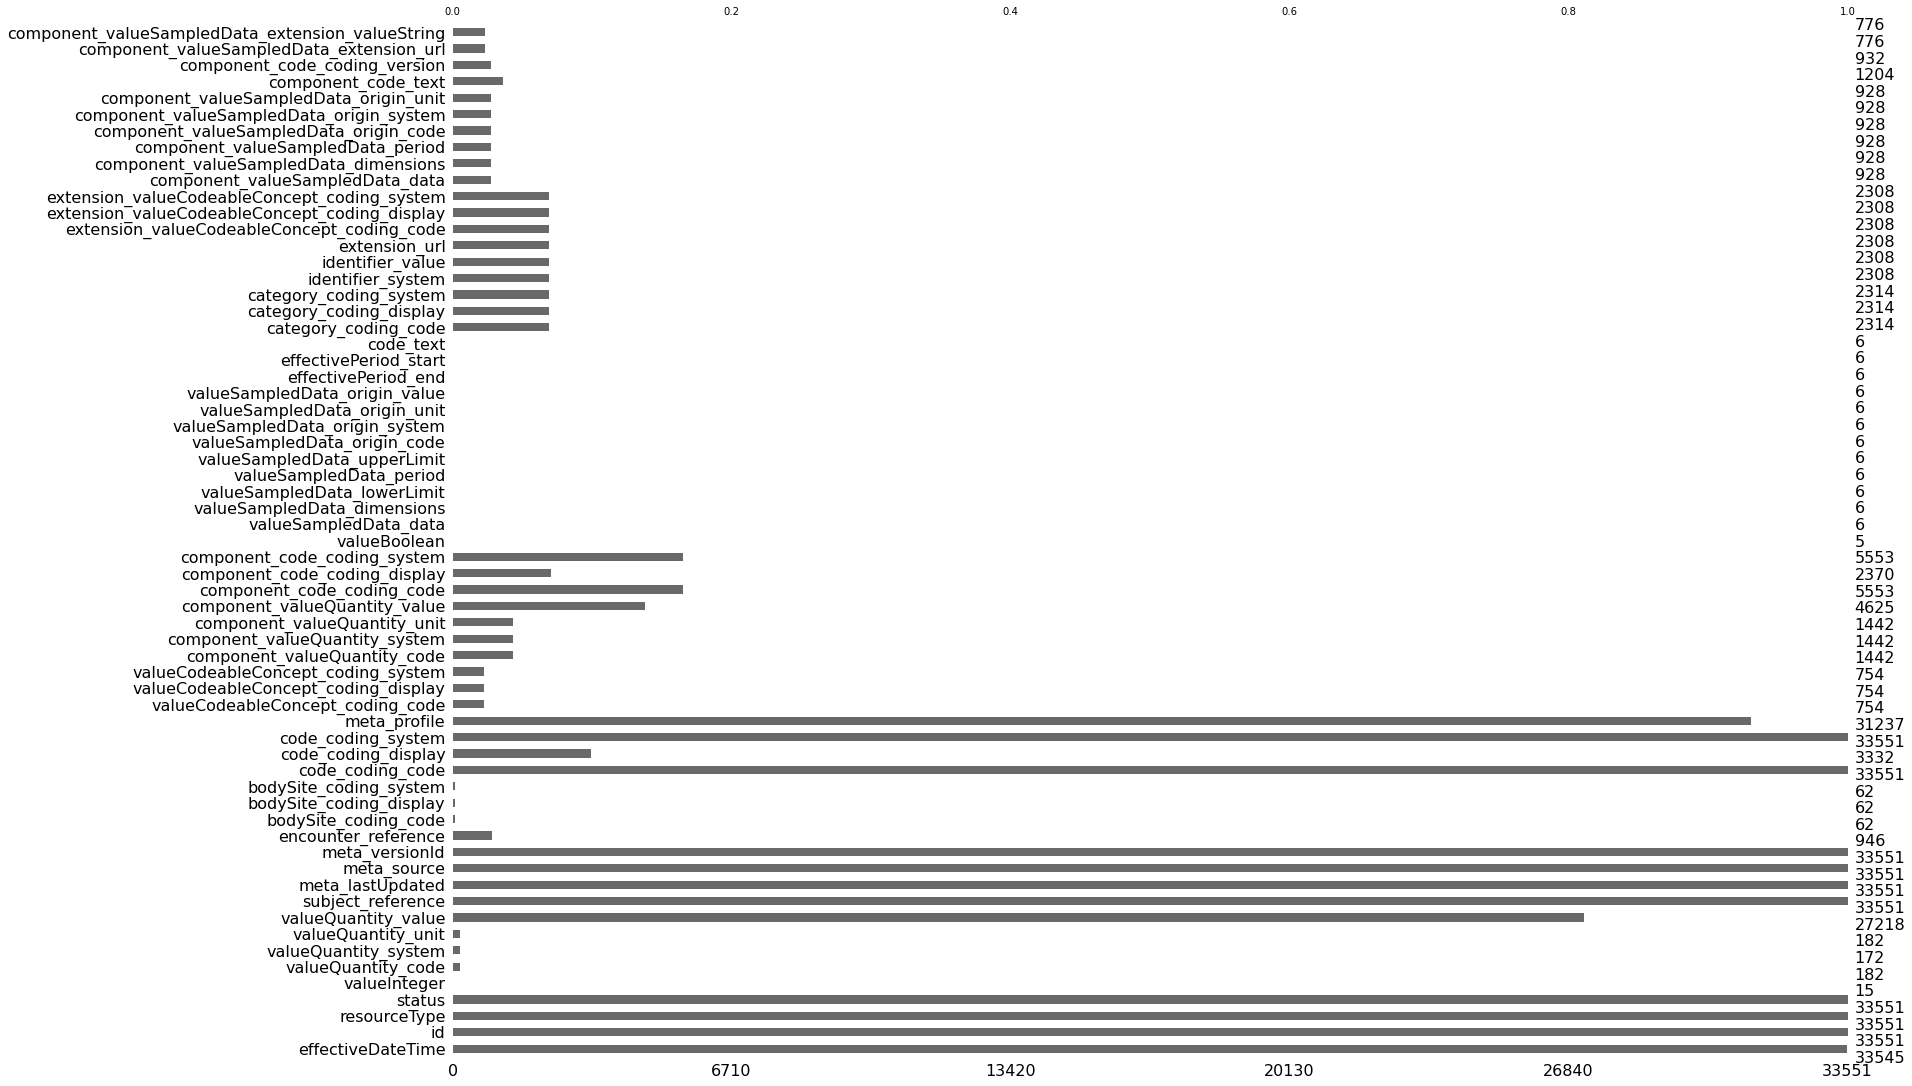

In [677]:
msno.bar(pd.DataFrame(observations.toPandas()))

<AxesSubplot:>

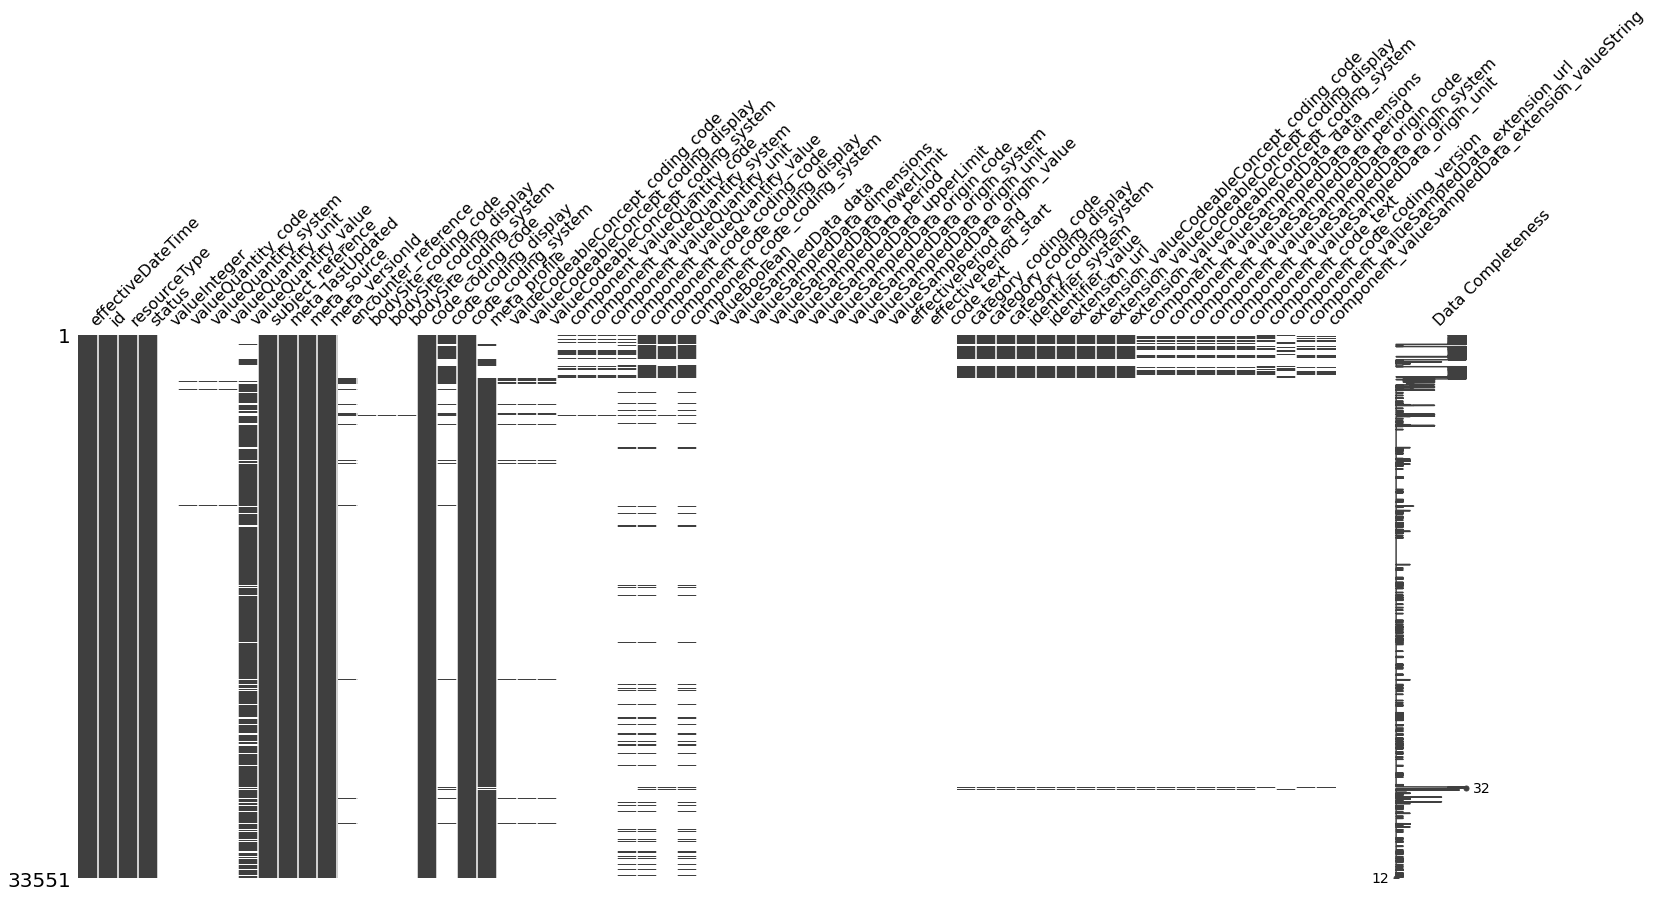

In [678]:
msno.matrix(pd.DataFrame(observations.toPandas()),labels=True)

<AxesSubplot:>

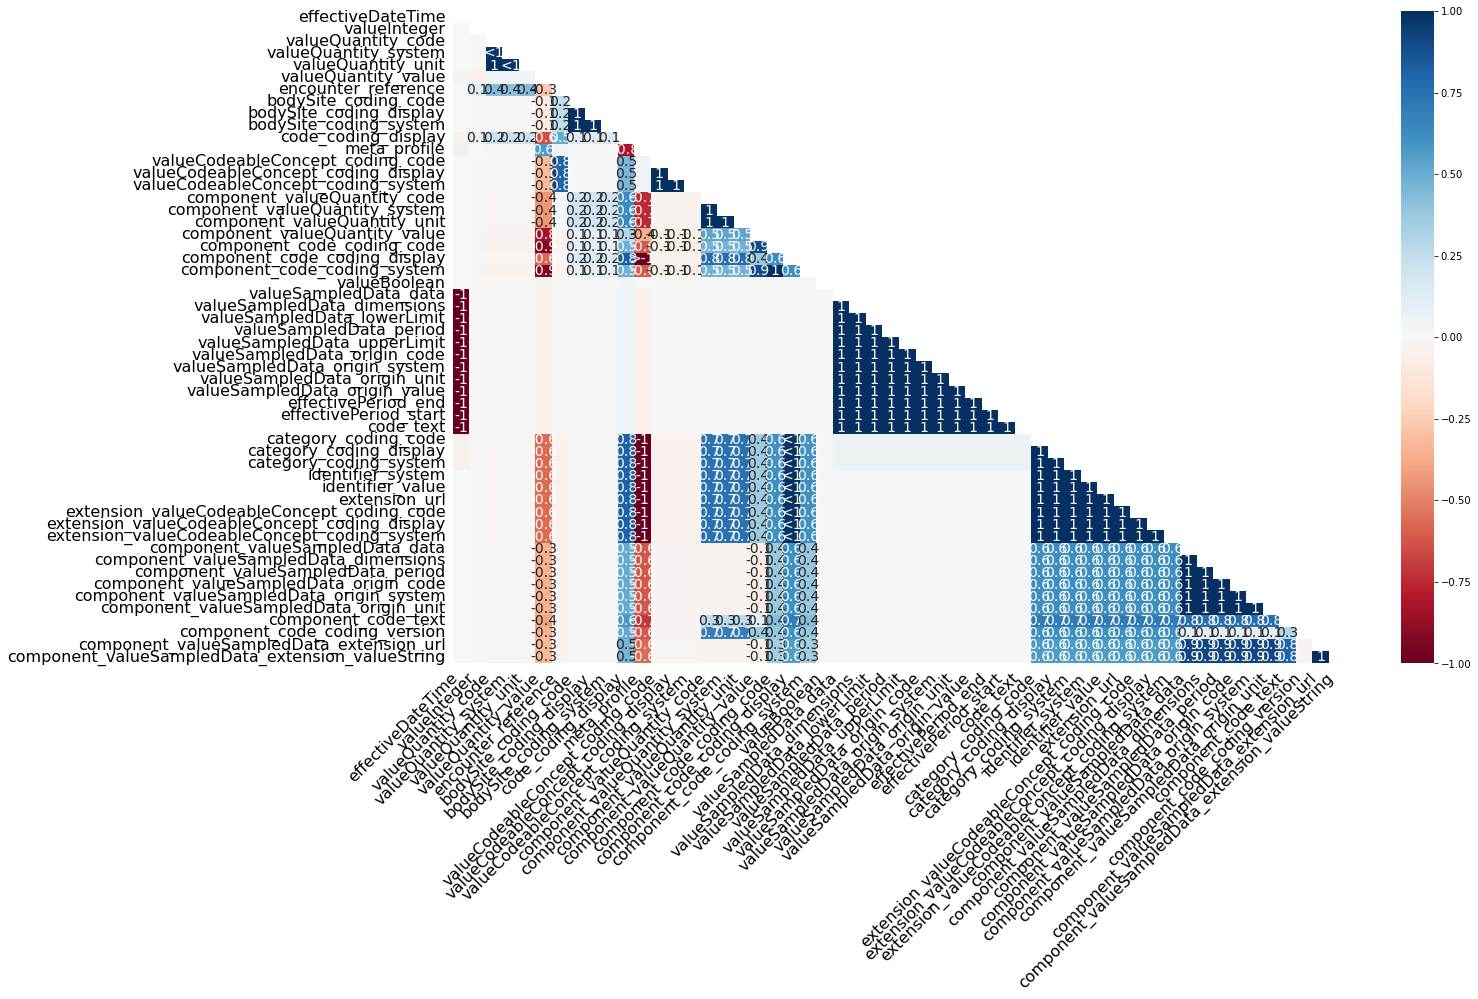

In [679]:

msno.heatmap(pd.DataFrame(observations.toPandas()))

<AxesSubplot:>

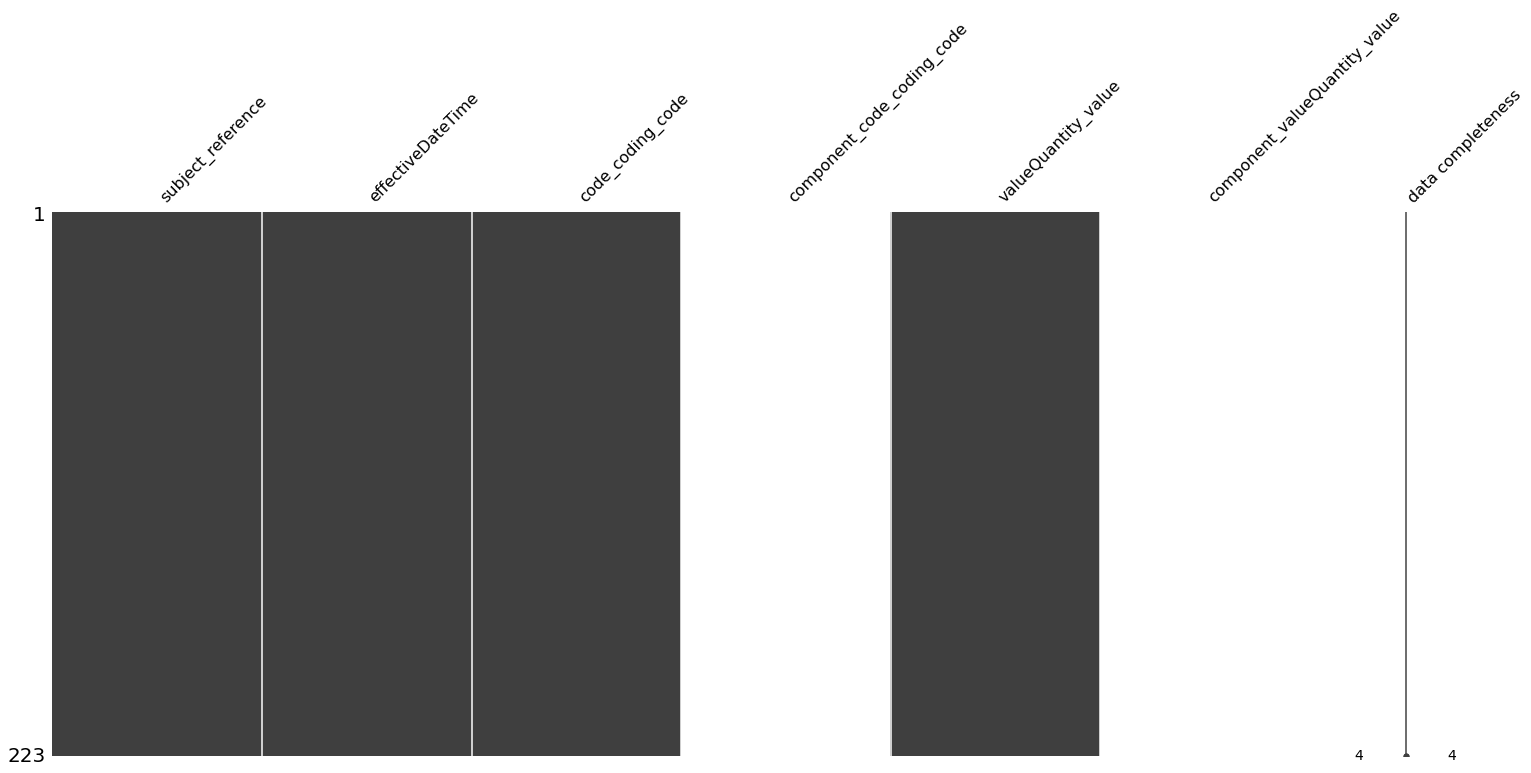

In [680]:
msno.matrix(pd.DataFrame(df.toPandas()),labels=True)

<AxesSubplot:>

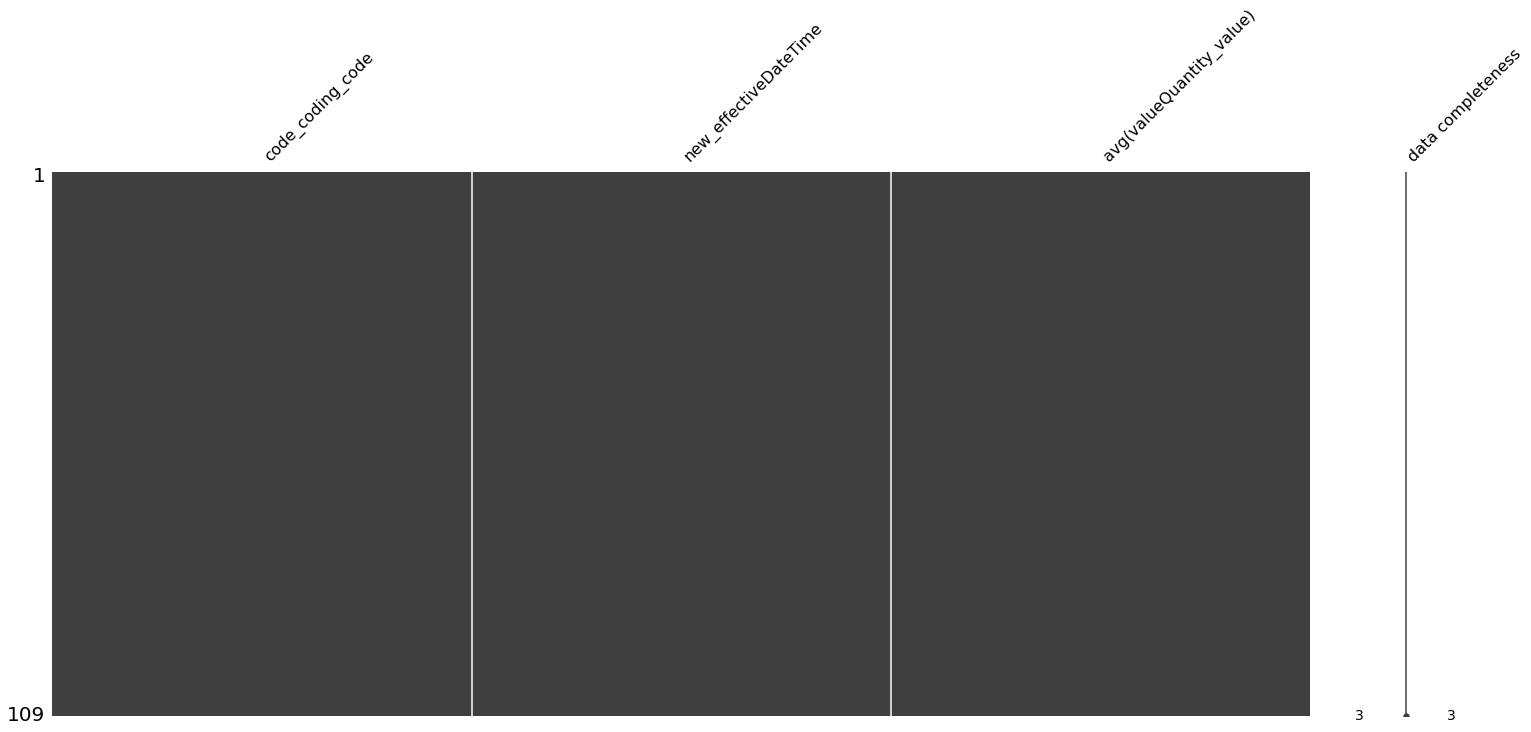

In [681]:

msno.matrix(pd.DataFrame(df1.toPandas()),labels=True)

<AxesSubplot:>

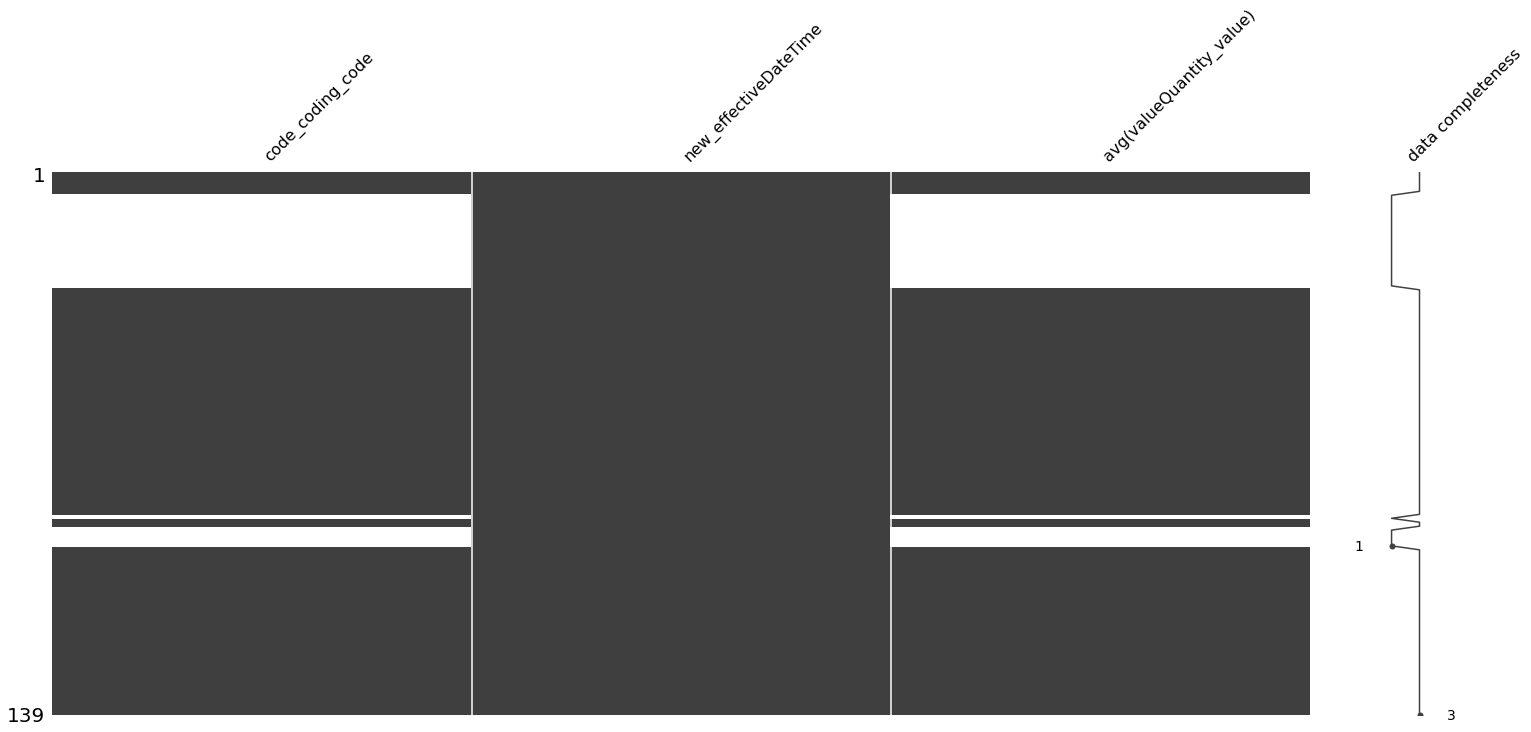

In [682]:

msno.matrix(pd.DataFrame(df2.toPandas()),labels=True)

In [683]:
def heartbeat_graph(x, y, title):
    hb_line = Line()
    hb_line.add_xaxis(x)
    hb_line.add_yaxis(title, y, 
        label_opts=opts.LabelOpts(is_show=False),
        markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_='average')]),
        markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_='min'), opts.MarkPointItem(type_='max')])
        # scale=True
        )
    hb_line.set_series_opts()
    hb_line.set_global_opts(
            title_opts=opts.TitleOpts(title=title),
            datazoom_opts=opts.DataZoomOpts(),
            xaxis_opts=opts.AxisOpts(splitline_opts=opts.SplitLineOpts(is_show=False)),
            yaxis_opts=opts.AxisOpts(
                axistick_opts=opts.AxisTickOpts(is_show=True),
                splitline_opts=opts.SplitLineOpts(is_show=True),
                min_=70,
                max_=100
            )
            )
    return hb_line

In [684]:
df3 = filter_observations('621892226','55425-3',None)
df3 = fill_missing_time_values(df3, TIME, [CODE], {VALUE:'avg'})
x = df_column_to_list(df3, 'new_effectiveDateTime')
y = df_column_to_list(df3, 'avg('+VALUE+')')
bar = heartbeat_graph(x, y, 'heart beat')
bar.render_notebook()


In [685]:
from sklearn.impute import SimpleImputer

def __fill_missing_with_imputer__(df:pyspark.sql.dataframe.DataFrame,
    columns, pdf:pd.DataFrame, imputer)->pyspark.sql.dataframe.DataFrame:
    if type(columns) is str:
        pdf[columns] = imputer.fit_transform(pdf[[columns]])
    elif type(columns) is list:
        for c in columns:
            pdf[c] = imputer.fit_transform(pdf[[c]])
    return spark.createDataFrame(pdf, schema=df.schema)

def fill_missing_with_mean(df:pyspark.sql.dataframe.DataFrame,
    columns)->pyspark.sql.dataframe.DataFrame:
    '''
    - coloumns

    see https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
    '''

    pdf = (pd.DataFrame(df.toPandas()))
    imputer = SimpleImputer(strategy='mean')
    return __fill_missing_with_imputer__(df,columns,pdf,imputer)

In [686]:
df4 = fill_missing_with_mean(df3, 'avg('+VALUE+')')

x = df_column_to_list(df4, 'new_effectiveDateTime')
y = df_column_to_list(df4, 'avg('+VALUE+')')
bar = heartbeat_graph(x, y, 'heart beat')
bar.render_notebook()

In [687]:
# df4 = imputation.fill_missing_with_median(df3, 'avg('+VALUE+')')


# x = df_column_to_list(df4, 'new_effectiveDateTime')
# y = df_column_to_list(df4, 'avg('+VALUE+')')
# bar = heartbeat_graph(x, y, 'heart beat')
# bar.render_notebook()

In [688]:
# df4 = imputation.fill_missing_with_KNN(df3, 'avg('+VALUE+')', n_neighbors=5, weights="distance")

# x = df_column_to_list(df4, 'new_effectiveDateTime')
# y = df_column_to_list(df4, 'avg('+VALUE+')')
# bar = heartbeat_graph(x, y, 'heart beat')
# bar.render_notebook()